# Проект модуля «Детектирование аномалий»

**ПОСТАНОВКА ЗАДАЧИ**

Оценить, есть ли влияние от рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.

**ПЛАН ПРОЕКТА:**
    
- парсинг данных о датах проведения передачи «Что? Где? Когда?»

- модель, предсказывающая значение временного ряда продаж. Показано, что нет положительного misprediction

- построение boxplot, указано, что нет аномалии роста продаж после передачи.

- попытка кластеризации точек продаж (по всем трём вендорам).

- lipton — 29;

- ahmad — 178; 

- may — 5152.

### Парсинг данных о датах проведения передачи «Что? Где? Когда?»

In [1]:
import requests
import re
from bs4 import BeautifulSoup

url = 'http://gameshows.ru/wiki/Что%3F_Где%3F_Когда%3F_(Сезон_2016)'

def _parsing(url):
    '''
    Парсим даты проведения викторины "Что? Где? Когда?"
    за указанный в url год
    '''
    user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"
    headers = {'User-Agent': user_agent} #задаем user-agent
    
    arr_dat = [] # Список дат
    
    response = requests.get(url, headers = headers)
    soup = BeautifulSoup(response.text, 'html.parser')#парсим текст
    div = soup.find_all('div', class_='mw-content-ltr')[0]
    
    table = div.find_all('table',attrs = {'class':'wikitable wikicenter'})[1]
    rows = table.select('a[href]')
    
    for i in range(len(rows)):
        try:
            el = re.findall(r'\d{4}-\d{2}-\d{2}',rows[i].attrs['title'])
            if len(el)>0:
                arr_dat.append(el[0])
        except:
            print(rows[i])
    
    return arr_dat

In [5]:
arr_dat = _parsing(url)
arr_dat

<a href="#cite_note-1">[прим. 1]</a>


['2016-03-27',
 '2016-04-03',
 '2016-04-10',
 '2016-04-17',
 '2016-04-24',
 '2016-05-15',
 '2016-05-22',
 '2016-05-29',
 '2016-06-05',
 '2016-06-19',
 '2016-09-25',
 '2016-10-02',
 '2016-10-09',
 '2016-10-16',
 '2016-10-23',
 '2016-11-20',
 '2016-11-27',
 '2016-12-11',
 '2016-12-18',
 '2017-01-02']

### Подготовка датасета

In [93]:
# Импортируем необходимые библиотека
import pandas as pd
import numpy as np
import os
import matplotlib
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from statsmodels.tsa.stattools import adfuller

In [94]:
path = r'F:\SkillFactory\Y2_U19'
df0 = pd.read_csv(os.path.join(path,"tea_demand.csv"), sep='\t')
df0['date'] = pd.to_datetime(df0['date'])

In [95]:
df0.head(3)

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622


In [96]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        459 non-null    int64         
 1   date            459 non-null    datetime64[ns]
 2   receipts_count  459 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.9 KB


In [97]:
459/3

153.0

In [98]:
dat = pd.DataFrame(arr_dat,columns=['date'])
dat['date'] = pd.to_datetime(dat['date'])
dat['ad'] = 1 # реклама в этот день

In [99]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    20 non-null     datetime64[ns]
 1   ad      20 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 448.0 bytes


In [100]:
# Добавляем в датасет рекламу
df0 = pd.merge(df0, dat, how='left') 
df0['ad'] = df0['ad'].fillna(0).astype('int8')

# Добавляем столбцы с номером месяца и днем недели
df0['month'] = df0['date'].dt.month
df0['dow'] = df0['date'].dt.dayofweek

# Новый признак: 
df0['WeekDay'] = (df0['dow'] < 5).astype(int)
df0['WeekDay'] = df0['WeekDay'] + 2*df0['ad']

In [101]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 0 to 458
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        459 non-null    int64         
 1   date            459 non-null    datetime64[ns]
 2   receipts_count  459 non-null    int64         
 3   ad              459 non-null    int8          
 4   month           459 non-null    int64         
 5   dow             459 non-null    int64         
 6   WeekDay         459 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(4), int8(1)
memory usage: 23.8 KB


In [102]:
df0['WeekDay'].value_counts()

1    327
0    111
2     21
Name: WeekDay, dtype: int64

In [103]:
df0[df0['ad']==1]

,brand_id,date,receipts_count,ad,month,dow,WeekDay
258,5152,2016-09-25,114,1,9,6,2
259,178,2016-09-25,223,1,9,6,2
260,29,2016-09-25,1053,1,9,6,2
279,5152,2016-10-02,120,1,10,6,2
280,178,2016-10-02,239,1,10,6,2
281,29,2016-10-02,596,1,10,6,2
300,5152,2016-10-09,114,1,10,6,2
301,178,2016-10-09,401,1,10,6,2
302,29,2016-10-09,617,1,10,6,2
321,5152,2016-10-16,193,1,10,6,2


**Визуализация продаж временого ряда по брендам и даты проведения рекламы**

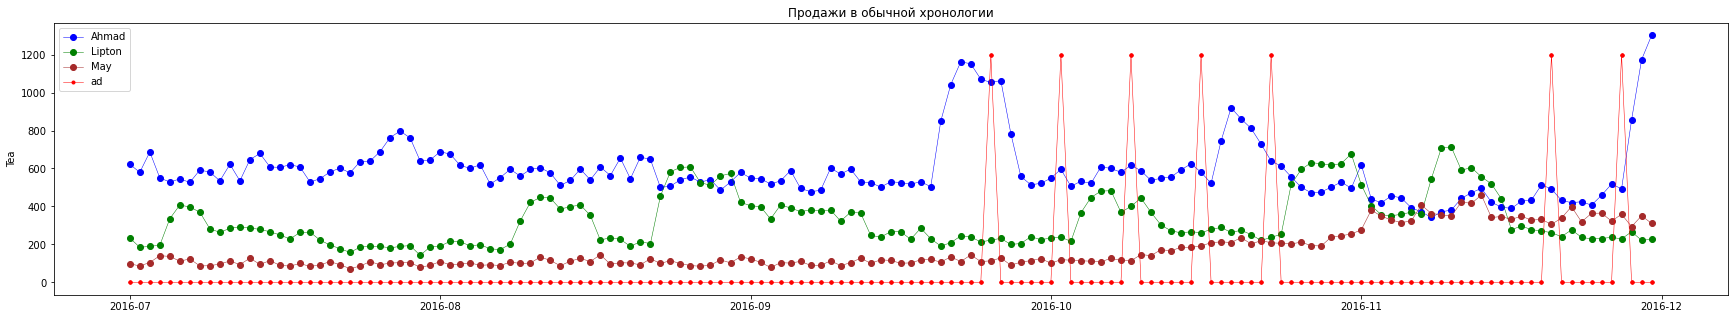

In [104]:
def visual_ads(df, _title, name_col, brand_id=[29,178,5152]):
    '''
    Рисуем хронологию продаж и рекламу
    '''
    colors = ['blue', 'green', 'brown']
    labels = ['Ahmad', 'Lipton', 'May']
    fig, ax = plt.subplots()
    fig.set_size_inches(30, 5)
    
    for i in range(len(brand_id)):
        
        ax.plot(df[df['brand_id']==brand_id[i]]['date'], df[df['brand_id']==brand_id[i]][name_col],
        marker='o', linestyle='-', linewidth=0.5, label=labels[i], color=colors[i])
    
    ax.plot(df['date'],1200*df['ad'],marker='.', linestyle='-', linewidth=0.5, label='ad', color='red')
    
    ax.set_ylabel('Tea')
    ax.set_title(_title)
    ax.legend();

    
name_col = 'receipts_count'
_title = 'Продажи в обычной хронологии'
visual_ads(df0, _title, name_col)

Для оценки влияния рекламы посмотрим продажи в течение недели. Для этого осуществим лагирование последующих 6 дней. Но предварительно выделим датасеты по брендам:

In [105]:
dfa = df0[df0['brand_id']==178].copy() #ahmad
dfl = df0[df0['brand_id']==29].copy() #lipton
dfm = df0[df0['brand_id']==5152].copy() #may

In [106]:
for i in range(1,7):
    dfa["shift"+str(i)] = dfa["receipts_count"].shift(-1*i)

In [107]:
dfa.set_index('date')

,brand_id,receipts_count,ad,month,dow,WeekDay,shift1,shift2,shift3,shift4,shift5,shift6
date,,,,,,,,,,,,
2016-07-01,178,234,0,7,4,1,185.0,190.0,196.0,336.0,408.0,397.0
2016-07-02,178,185,0,7,5,0,190.0,196.0,336.0,408.0,397.0,370.0
2016-07-03,178,190,0,7,6,0,196.0,336.0,408.0,397.0,370.0,282.0
2016-07-04,178,196,0,7,0,1,336.0,408.0,397.0,370.0,282.0,264.0
2016-07-05,178,336,0,7,1,1,408.0,397.0,370.0,282.0,264.0,285.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-26,178,238,0,11,5,0,229.0,267.0,222.0,227.0,NaN,NaN
2016-11-27,178,229,1,11,6,2,267.0,222.0,227.0,NaN,NaN,NaN
2016-11-28,178,267,0,11,0,1,222.0,227.0,NaN,NaN,NaN,NaN


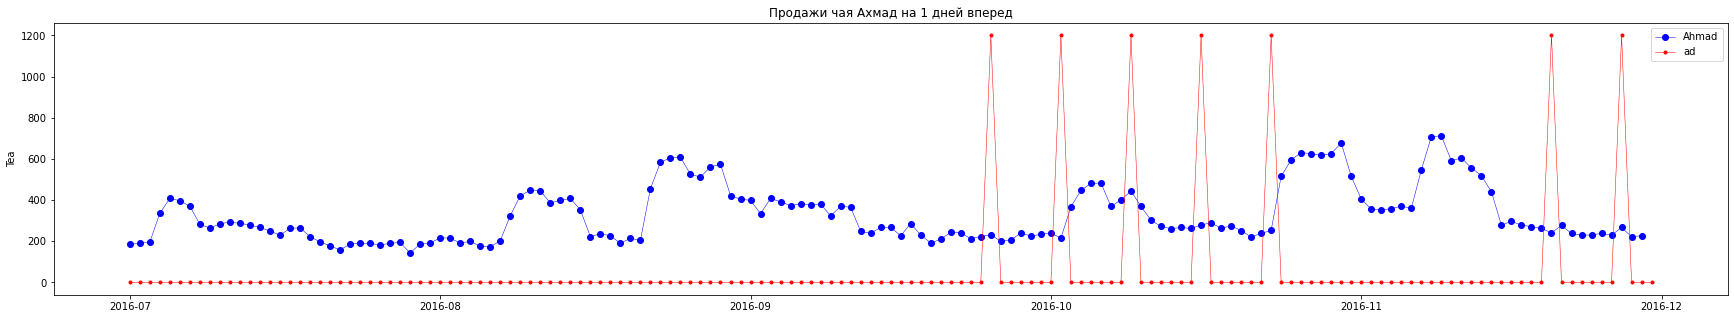

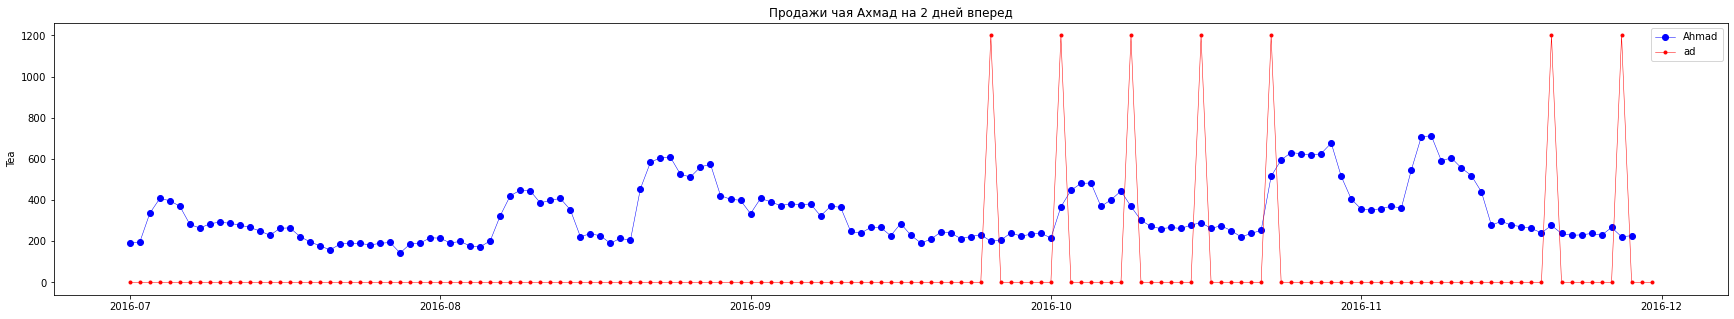

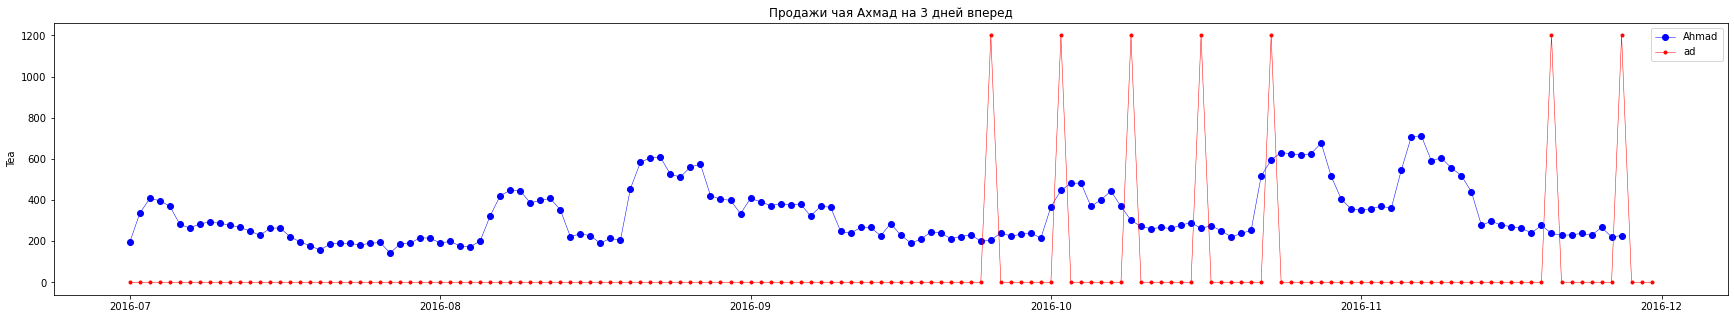

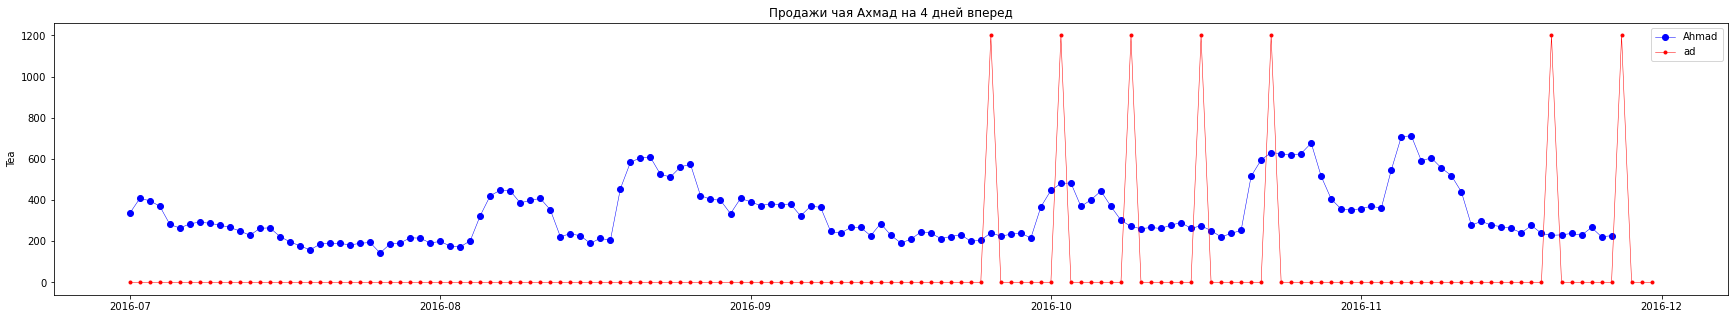

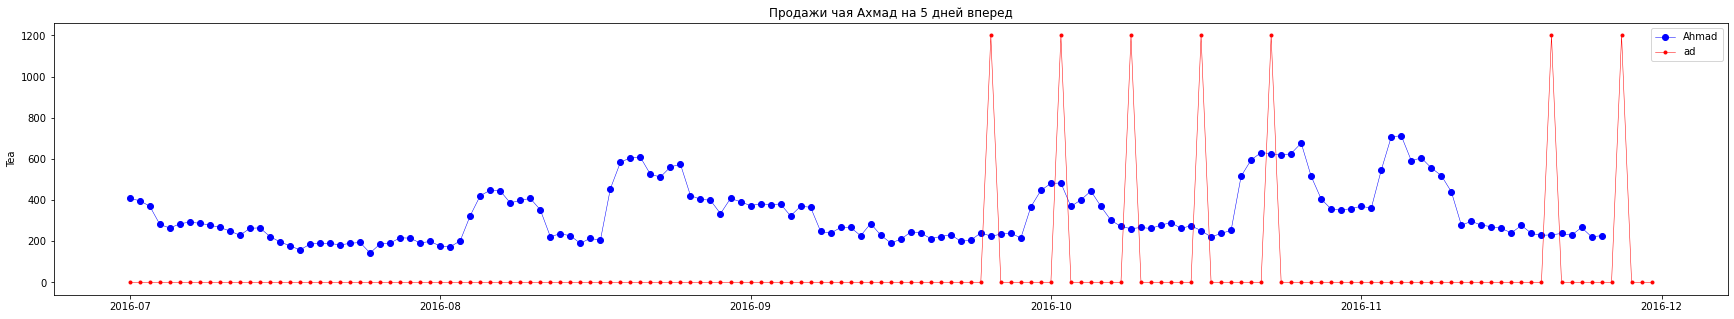

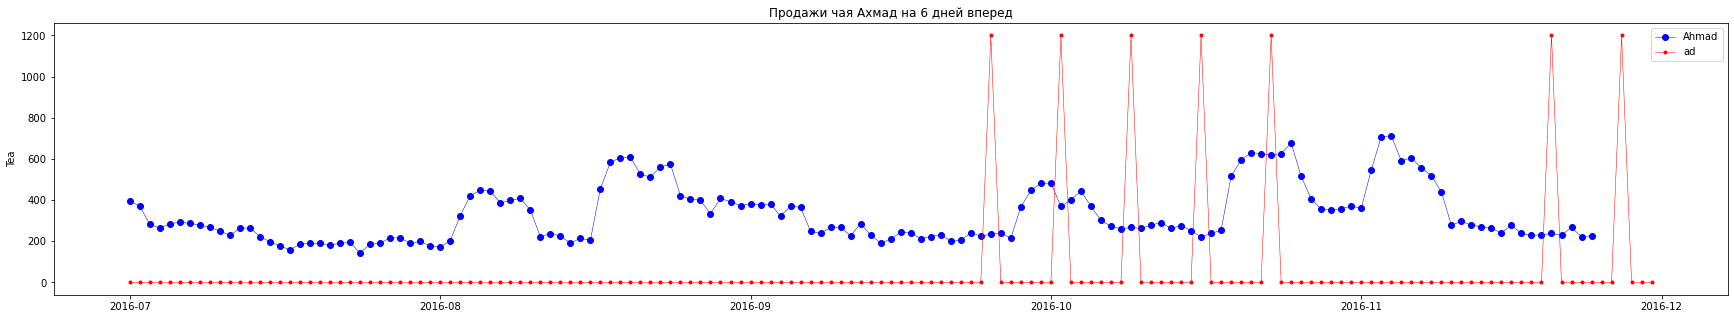

In [108]:
for i in range(1,7):
    name_col = 'shift'+str(i)
    _title = f'Продажи чая Ахмад на {i} дней вперед'
    visual_ads(dfa,_title, name_col, brand_id=[178,])
        

In [109]:
dfa['sum_sales_7'] = dfa['shift1'] + dfa['shift2'] + dfa['shift3'] + dfa['shift4'] + dfa['shift5'] + dfa['shift6']\
    + dfa['receipts_count']

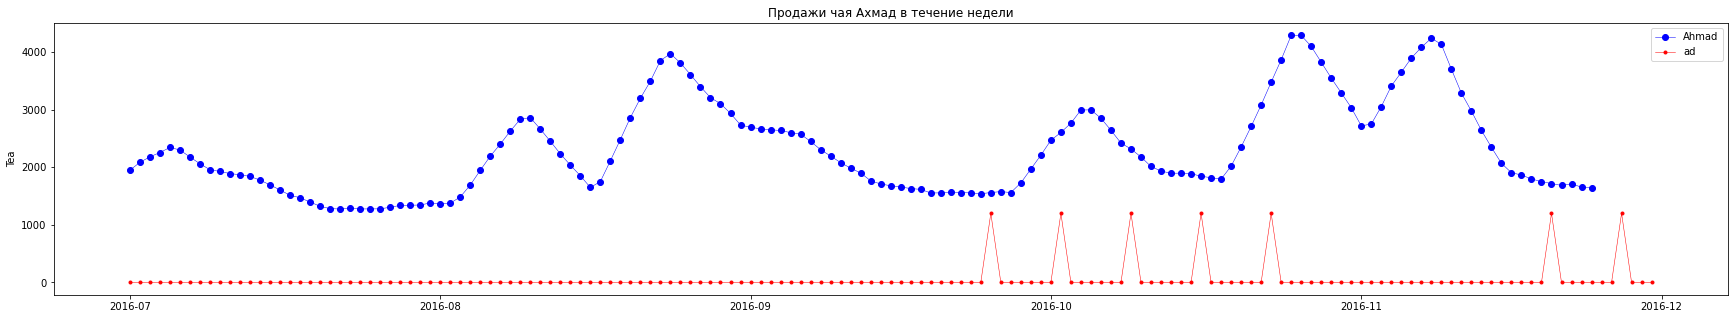

In [110]:
name_col = 'sum_sales_7'
_title = f'Продажи чая Ахмад в течение недели'
visual_ads(dfa,_title, name_col, brand_id=[178,])

Рассматривая последний график, хочется сделать вывод, что 5 недель рекламы осенью (5 пиков)принесли свои плоды и мы видим после этого на протяжении последующего времени подъем продаж по сравнению с предыдущим периодом. Однако, как тогда объяснить 2 пика подъема в летнее время, когда рекламы не было?

*Вывод:* Визуально четкой связи между рекламой и продажами не наблюдается

**EDA**

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

receipts_count                        
              median         std        mean
month                                       
7              229.0   68.363120  241.870968
8              353.0  151.332170  351.322581
9              257.5   75.444400  289.933333
10             302.0  149.505177  379.741935
11             324.0  151.618051  372.633333

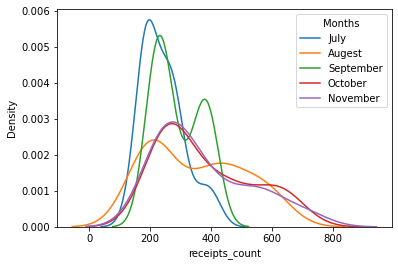

In [111]:
for i in range(7,12):
    sns.distplot(df0[(df0['month']==i) & (df0['brand_id']==178)]['receipts_count'], hist=False, label=str(i))
plt.legend(title='Months', loc='upper right', labels=['July', 'Augest','September','October',"November",'December'])    
df0[df0['brand_id']==178].groupby('month').agg({'receipts_count': {'mean','median','std'}})    

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

sum_sales_7                         
           median         std         mean
month                                     
7          1605.0  369.927279  1676.483871
8          2625.0  759.330791  2584.870968
9          1745.5  425.734671  1956.300000
10         2640.0  777.855028  2746.612903
11         2678.0  919.755945  2693.291667

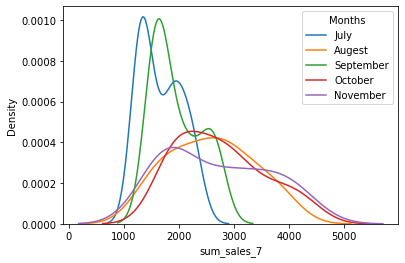

In [112]:
for i in range(7,12):
    sns.distplot(dfa[dfa['month']==i]['sum_sales_7'], hist=False, label=str(i))
plt.legend(title='Months', loc='upper right', labels=['July', 'Augest','September','October',"November",'December'])    
dfa.groupby('month').agg({'sum_sales_7': {'mean','median','std'}})    

In [113]:
dfa

,brand_id,date,receipts_count,ad,month,dow,WeekDay,shift1,shift2,shift3,shift4,shift5,shift6,sum_sales_7
1,178,2016-07-01,234,0,7,4,1,185.0,190.0,196.0,336.0,408.0,397.0,1946.0
4,178,2016-07-02,185,0,7,5,0,190.0,196.0,336.0,408.0,397.0,370.0,2082.0
7,178,2016-07-03,190,0,7,6,0,196.0,336.0,408.0,397.0,370.0,282.0,2179.0
10,178,2016-07-04,196,0,7,0,1,336.0,408.0,397.0,370.0,282.0,264.0,2253.0
13,178,2016-07-05,336,0,7,1,1,408.0,397.0,370.0,282.0,264.0,285.0,2342.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,178,2016-11-26,238,0,11,5,0,229.0,267.0,222.0,227.0,NaN,NaN,NaN
448,178,2016-11-27,229,1,11,6,2,267.0,222.0,227.0,NaN,NaN,NaN,NaN
451,178,2016-11-28,267,0,11,0,1,222.0,227.0,NaN,NaN,NaN,NaN,NaN
454,178,2016-11-29,222,0,11,1,1,227.0,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

receipts_count                        
                median         std        mean
WeekDay                                       
0                267.0  138.367764  312.027027
1                279.0  136.279497  336.137615
2                239.0   61.885455  264.857143

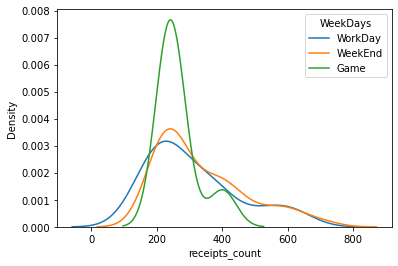

In [114]:
for i in range(0,8):
    sns.distplot(df0[(df0['WeekDay']==i) & (df0['brand_id']==178)]['receipts_count'], hist=False, label=str(i))
plt.legend(title='WeekDays', loc='upper right', labels=['WorkDay', 'WeekEnd','Game'])    
df0[df0['brand_id']==178].groupby('WeekDay').agg({'receipts_count': {'mean','median','std'}})    

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

receipts_count                        
                median         std        mean
WeekDay                                       
0                546.0  107.251690  572.729730
1                555.0  174.421841  595.174312
2                596.0  191.543604  638.571429

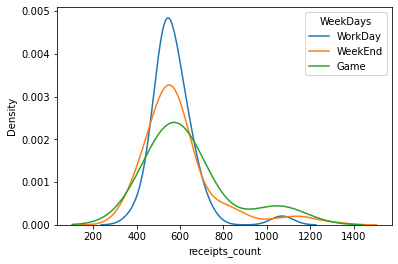

In [115]:
for i in range(0,8):
    sns.distplot(df0[(df0['WeekDay']==i) & (df0['brand_id']==29)]['receipts_count'], hist=False, label=str(i))
plt.legend(title='WeekDays', loc='upper right', labels=['WorkDay', 'WeekEnd','Game'])    
df0[df0['brand_id']==29].groupby('WeekDay').agg({'receipts_count': {'mean','median','std'}})  

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

receipts_count                        
                median         std        mean
WeekDay                                       
0                102.0  104.904762  151.864865
1                121.0   97.359177  171.073394
2                193.0   98.155368  202.142857

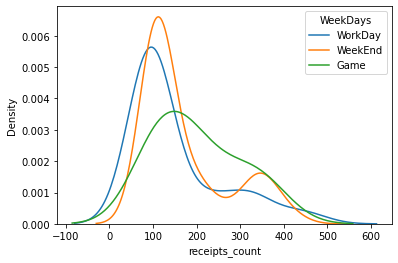

In [116]:
for i in range(0,8):
    sns.distplot(df0[(df0['WeekDay']==i) & (df0['brand_id']==5152)]['receipts_count'], hist=False, label=str(i))
plt.legend(title='WeekDays', loc='upper right', labels=['WorkDay', 'WeekEnd','Game'])    
df0[df0['brand_id']==5152].groupby('WeekDay').agg({'receipts_count': {'mean','median','std'}})  

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

receipts_count                        
            median         std        mean
dow                                       
0            265.0  134.448754  317.090909
1            330.0  119.649560  343.727273
2            282.5  145.664859  339.181818
3            279.0  151.525780  349.190476
4            267.0  139.278723  332.090909
5            258.5  134.304429  298.818182
6            262.0  128.191795  310.227273

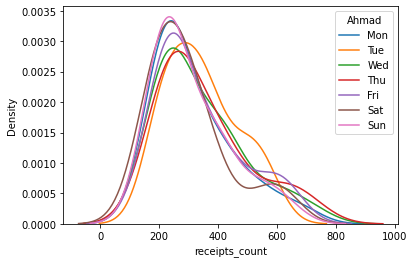

In [117]:
for i in range(0,8):
    sns.distplot(df0[(df0['dow']==i) & (df0['brand_id']==178)]['receipts_count'], hist=False, label=str(i))
plt.legend(title='Ahmad', loc='upper right', labels=['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun'])    
df0[df0['brand_id']==178].groupby('dow').agg({'receipts_count': {'mean','median','std'}})  

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

receipts_count                        
            median         std        mean
dow                                       
0            588.5  147.376957  587.590909
1            536.0  177.345219  593.772727
2            547.5  221.317782  609.318182
3            550.0  177.245673  584.142857
4            592.5  154.804247  600.545455
5            547.5  126.042664  577.090909
6            566.0  124.305839  589.318182

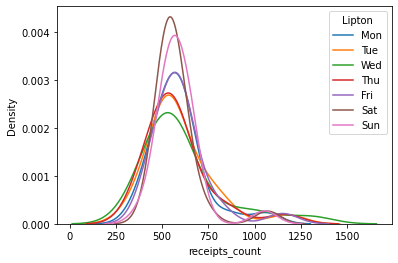

In [118]:
for i in range(0,8):
    sns.distplot(df0[(df0['dow']==i) & (df0['brand_id']==29)]['receipts_count'], hist=False, label=str(i))
plt.legend(title='Lipton', loc='upper right', labels=['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun'])    
df0[df0['brand_id']==29].groupby('dow').agg({'receipts_count': {'mean','median','std'}})  

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

receipts_count                        
            median         std        mean
dow                                       
0            127.5   92.610026  174.954545
1            110.5  105.714975  169.681818
2            131.5   97.233418  176.636364
3            116.0   98.088978  168.380952
4            115.5  101.436191  165.590909
5            101.5  103.836545  155.136364
6            113.0  107.229464  164.590909

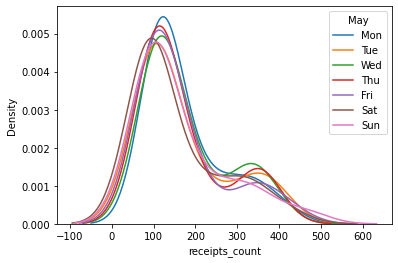

In [119]:
for i in range(0,8):
    sns.distplot(df0[(df0['dow']==i) & (df0['brand_id']==5152)]['receipts_count'], hist=False, label=str(i))
plt.legend(title='May', loc='upper right', labels=['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun'])    
df0[df0['brand_id']==5152].groupby('dow').agg({'receipts_count': {'mean','median','std'}})  

**Поиск аномалий с помощью BoxPlot и IQR**

Поищем аномалии по количеству продаж чая на все датасете. На бохплоте заметно несколько значений, находящихся выше верхнего уса. Найдем их точное значение с использованием статистик:

<AxesSubplot:>

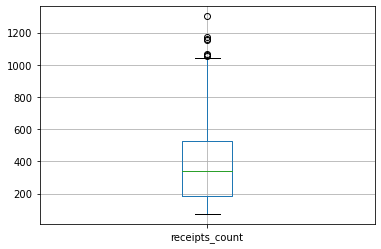

In [120]:
df0.boxplot(column=['receipts_count'])

In [121]:
import scipy
iqr = scipy.stats.iqr(df0.receipts_count)
print(iqr)
df0[df0.receipts_count>np.percentile(df0.receipts_count,75) + 1.5*iqr].receipts_count.count()

342.5


7

In [122]:
df0[df0['receipts_count']>1050]

,brand_id,date,receipts_count,ad,month,dow,WeekDay
251,29,2016-09-22,1162,0,9,3,1
254,29,2016-09-23,1151,0,9,4,1
257,29,2016-09-24,1070,0,9,5,0
260,29,2016-09-25,1053,1,9,6,2
263,29,2016-09-26,1063,0,9,0,1
455,29,2016-11-29,1173,0,11,1,1
458,29,2016-11-30,1301,0,11,2,1


In [123]:
arr_dat

['2016-03-27',
 '2016-04-03',
 '2016-04-10',
 '2016-04-17',
 '2016-04-24',
 '2016-05-15',
 '2016-05-22',
 '2016-05-29',
 '2016-06-05',
 '2016-06-19',
 '2016-09-25',
 '2016-10-02',
 '2016-10-09',
 '2016-10-16',
 '2016-10-23',
 '2016-11-20',
 '2016-11-27',
 '2016-12-11',
 '2016-12-18',
 '2017-01-02']

Для всего набора данных по статистической оценке мы находим 7 аномально больших значений. При этом хорошо видно, что больше половины аномальных выбросов не связано с рекламой чая (продажи 25 сентября в день рекламы, проходящей в вечернее время не может поднять продажи в этот день) )

Поищем аномалии по количеству продаж чая для каждого бренда отдельно. На бохплоте заметно несколько значений, находящихся выше верхнего уса. Найдем их точное значение с использованием статистик:

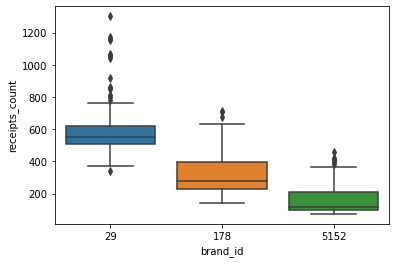

In [124]:
ax = sns.boxplot(x="brand_id", y="receipts_count", data=df0)

При рассмотрении продаж по отдельным брендам: Ахмад только 3 значения аномально велики,
Липтон - 15, Май - 6.

In [125]:
#Ahmad
iqr = scipy.stats.iqr(dfa.receipts_count)
print(iqr)
dfa[dfa.receipts_count>np.percentile(dfa.receipts_count,75) + 1.5*iqr].receipts_count.count()

172.0


3

In [126]:
#Lipton
iqr = scipy.stats.iqr(dfl.receipts_count)
print(iqr)
dfl[dfl.receipts_count>np.percentile(dfl.receipts_count,75) + 1.5*iqr].receipts_count.count()

109.0


15

In [127]:
#May
iqr = scipy.stats.iqr(dfm.receipts_count)
print(iqr)
dfm[dfm.receipts_count>np.percentile(dfm.receipts_count,75) + 1.5*iqr].receipts_count.count()

108.0


6

А теперь посмотрим продажи чая Ахмад суммарные за 7 дней, интересно, что здесь аномалией не наблюдается совсем:

<AxesSubplot:>

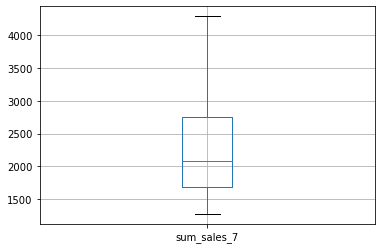

In [128]:
dfa.boxplot(column=['sum_sales_7'])

**Clustering models**

In [130]:
data = df0[['receipts_count', 'brand_id', 'month', 'dow', 'WeekDay']]
# Нормализуем наши данные
starrd_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = starrd_scaler.transform(data)
data = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "


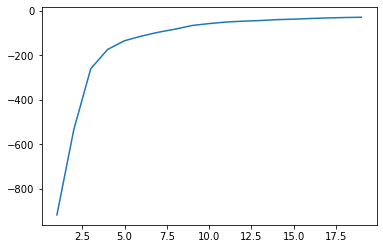

In [131]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j).fit(data) for j in n_cluster]
scores = [km.score(data) for km in kmeans]
#TODO давайте подберем оптимальное число кластеров k-means
#TODO обучить KMeans для заданных числе кластеров
#TODO как подобрать число кластеров?
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [132]:
df0['cluster'] = kmeans[2].predict(data)
df0['principal_feature1'] = data[0]
df0['principal_feature2'] = data[1]
df0['cluster'].value_counts()

1    232
2    116
0    111
Name: cluster, dtype: int64

Визуализируем разложение по брендам:

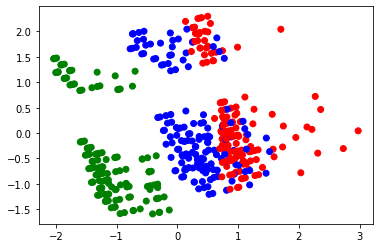

In [135]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df0['principal_feature1'], df0['principal_feature2'], c=df0["brand_id"].apply(lambda x: colors[len(str(x))-2]))
plt.show()

Визуализуруем разбиение по трем кластерам:

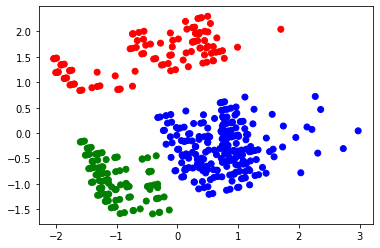

In [137]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df0['principal_feature1'], df0['principal_feature2'], c=df0["cluster"].apply(lambda x: colors[x]))
plt.show()

В силу того, что у нас имеется 2 группы точек, и все три бренда попадают в эти группы, попробуем разбить их на 6 кластеров:

In [138]:
df0['cluster'] = kmeans[5].predict(data)
df0['principal_feature1'] = data[0]
df0['principal_feature2'] = data[1]
df0['cluster'].value_counts()

1    114
4     89
5     75
0     74
2     70
3     37
Name: cluster, dtype: int64

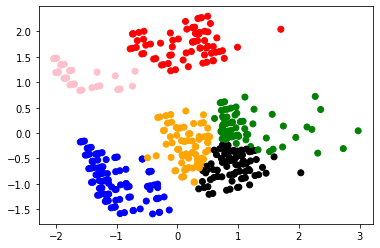

In [139]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df0['principal_feature1'], df0['principal_feature2'], c=df0["cluster"].apply(lambda x: colors[x]))
plt.show()

И тоже получилось не совсем то, что надо: в верхней группе 2 бренда, а в нижней - 4.

In [140]:
# Несколько вспомогательных методов

def getDistanceByPoint(data, model):
    # Расчет расстояний от точек до центров кластеров
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
        #distance.append(np.linalg.norm(Xa-Xb))
    return distance

def getTransitionMatrix (df):
    # Расчет вероятностей перехода к следующему состоянию (глупая предсказывалка)
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    # Поиск аномалий в последовательности сигналов исходя из марковской матрицы переходов
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


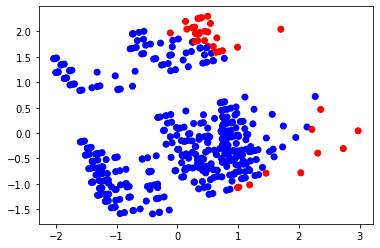

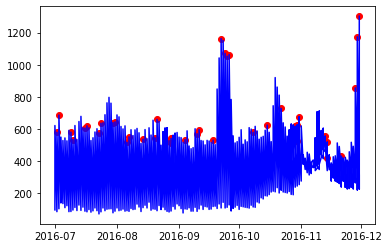

In [142]:
outliers_fraction = 0.01
distance = getDistanceByPoint(data, kmeans[2])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# Считаем точку аномалией, если расстояние до центра кластера больше порога
df0['anomaly21'] = (distance >= 3.0).astype(int)

fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df0['principal_feature1'], df0['principal_feature2'], c=df0["anomaly21"].apply(lambda x: colors[x]))
plt.show()

fig, ax = plt.subplots()

a = df0.loc[df0['anomaly21'] == 1, ['date', 'receipts_count']] #anomaly

ax.plot(df0['date'], df0['receipts_count'], color='blue')
ax.scatter(a['date'],a['receipts_count'], color='red')
plt.show()

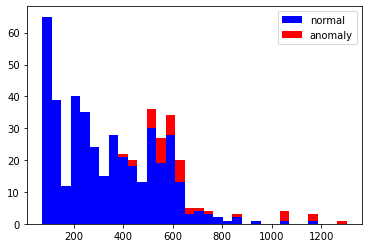

In [144]:
# Посмотрим на распределение аномальных и действительных значений
a = df0.loc[df0['anomaly21'] == 0, 'receipts_count']
b = df0.loc[df0['anomaly21'] == 1, 'receipts_count']
fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [145]:
# creation of 3 differents data set based on brand_id defined before
df_class0 = dfl['receipts_count']
df_class1 = dfa['receipts_count']
df_class2 = dfm['receipts_count']


<AxesSubplot:>

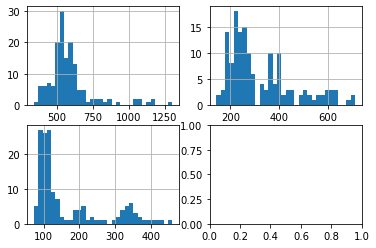

In [146]:
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)

In [147]:
# Попробуем статистически оценить количество аномалий

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


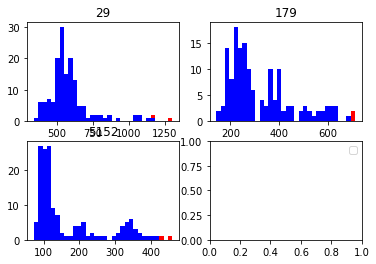

In [148]:
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'receipts_count']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'receipts_count']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'receipts_count']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'receipts_count']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'receipts_count']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'receipts_count']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

axs[0,0].set_title("29")
axs[0,1].set_title("179")
axs[1,0].set_title("5152")

plt.legend()
plt.show()

In [149]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2])
df0['anomaly22'] = df_class['anomaly']
df0['anomaly22'] = np.array(df0['anomaly22'] == -1).astype(int) 

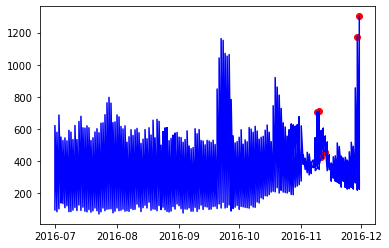

In [150]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df0.loc[df0['anomaly22'] == 1, ('date', 'receipts_count')] #anomaly

ax.plot(df0['date'], df0['receipts_count'], color='blue')
ax.scatter(a['date'],a['receipts_count'], color='red')
plt.show()

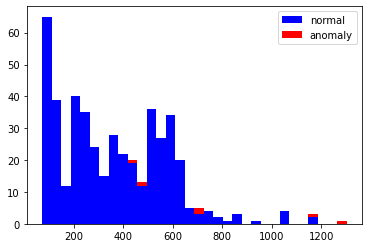

In [151]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df0.loc[df0['anomaly22'] == 0, 'receipts_count']
b = df0.loc[df0['anomaly22'] == 1, 'receipts_count']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

**Тест Дики-Фуллера**

In [152]:
def print_diki_fuller(test):
    
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
        print ('ряд не стационарен')
    else:
        print ('ряд стационарен')

In [153]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def adfuller_test(series, signif=0.05, name='', verbose=False):
    '''
    ADFuller test для стационарных рядов и печать отчета
    '''
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1],4), 'n_lags': round(r[2], 4), 'n_obs': r[3]}
    p_value = output['pvalue']
    
    def adjust(val, length=6): return str(val).ljust(length)
    
    # Print summary
    print(f' Augmented Dickey-Fuller Test on "{name}"', '\n ', '-'*50)
    print(f' Null Hypothesis: Data has unit root/ Non-Stationary')
    print(f' Significant Level = {signif}')
    print(f' Test Statistic = {output["test_statistic"]}')
    print(f' No. Lags Chosen = {output["n_lags"]}')
    
    for key, val in r[4].items():
        print(f' Critical Value  {adjust(key)} = {round(val, 3)}')
        
    if p_value <= signif:
        print(f' => P_Value = {p_value}. Rejecting Null Hypothesis.')
        print(f' => Series is Stationary')
    else:
        print(f' => P_Value = {p_value}. Week evidence to reject the Null Hypothesis.')
        print(f' => Series is Non - Stationary')

In [154]:
test = adfuller(dfm['receipts_count'])
print_diki_fuller(test)    

adf:  -0.6711647695731432
p-value:  0.8540778183455848
Critical values:  {'1%': -3.4744158894942156, '5%': -2.880878382771059, '10%': -2.577081275821236}
ряд не стационарен


In [155]:
test = adfuller(dfl['receipts_count'])
print_diki_fuller(test)    

adf:  -3.044005580472901
p-value:  0.0309842238093317
Critical values:  {'1%': -3.4744158894942156, '5%': -2.880878382771059, '10%': -2.577081275821236}
ряд стационарен


In [156]:
test = adfuller(dfa['receipts_count'])
print_diki_fuller(test)    

adf:  -2.195736107443921
p-value:  0.20779664213973786
Critical values:  {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
ряд не стационарен


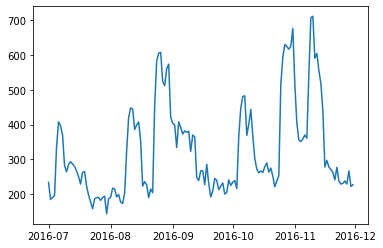

In [157]:
plt.plot(dfa['date'], dfa['receipts_count'])
plt.show()

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

receipts_count                        
              median         std        mean
month                                       
7              229.0   68.363120  241.870968
8              353.0  151.332170  351.322581
9              257.5   75.444400  289.933333
10             302.0  149.505177  379.741935
11             324.0  151.618051  372.633333

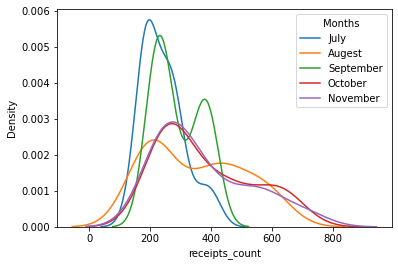

In [158]:
import seaborn as sns
for i in range(7,12):
    sns.distplot(dfa[(dfa['month']==i)]['receipts_count'], hist=False, label=str(i))
plt.legend(title='Months', loc='upper right', labels=['July', 'Augest','September','October',"November",'December'])    
dfa.groupby('month').agg({'receipts_count': {'mean','median','std'}})    

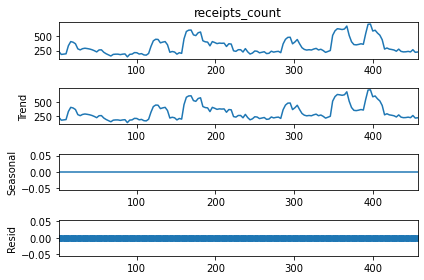

In [159]:
#import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(x=dfa['receipts_count'],period=1).plot()
plt.show()

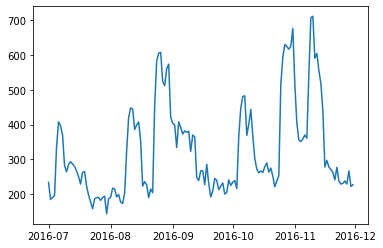

In [160]:
plt.plot(dfa['date'], dfa['receipts_count'])
plt.show()

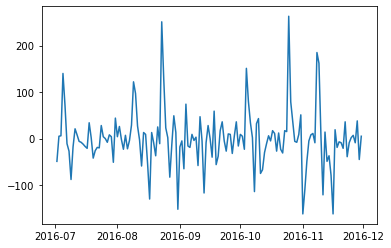

In [161]:
plt.plot(dfa['date'], dfa['receipts_count'].diff())
plt.show()

In [162]:
test = adfuller(dfa['receipts_count'].diff()[1:])
print_diki_fuller(test)    

adf:  -6.874263180315062
p-value:  1.4884446590032763e-09
Critical values:  {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
ряд стационарен


In [163]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

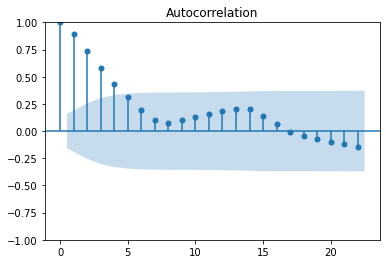

In [164]:
plot_acf(dfa['receipts_count'])
plt.show()

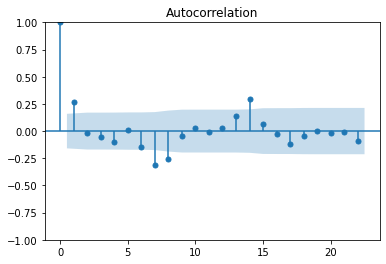

In [165]:
plot_acf(dfa['receipts_count'].diff().dropna())
plt.show()

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


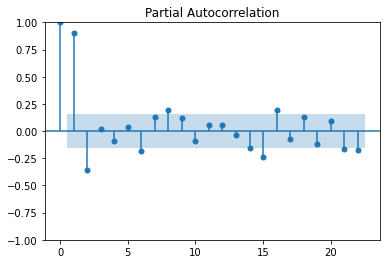

In [166]:
plot_pacf(dfa['receipts_count'])
plt.show()

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


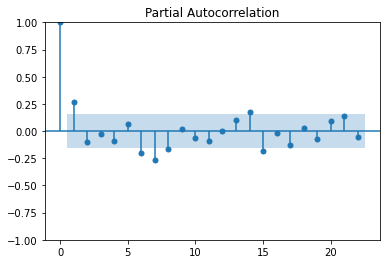

In [167]:
plot_pacf(dfa['receipts_count'].diff().dropna())
plt.show()

In [169]:
adfuller_test(dfa['receipts_count'], signif=0.05, name='receipts_count', verbose=False)

 Augmented Dickey-Fuller Test on "receipts_count" 
  --------------------------------------------------
 Null Hypothesis: Data has unit root/ Non-Stationary
 Significant Level = 0.05
 Test Statistic = -2.1957
 No. Lags Chosen = 8
 Critical Value  1%     = -3.477
 Critical Value  5%     = -2.882
 Critical Value  10%    = -2.578
 => P_Value = 0.2078. Week evidence to reject the Null Hypothesis.
 => Series is Non - Stationary


In [170]:
adfuller_test(dfa['receipts_count'].diff().dropna(), signif=0.05, name='receipts_count', verbose=False)

 Augmented Dickey-Fuller Test on "receipts_count" 
  --------------------------------------------------
 Null Hypothesis: Data has unit root/ Non-Stationary
 Significant Level = 0.05
 Test Statistic = -6.8743
 No. Lags Chosen = 7
 Critical Value  1%     = -3.477
 Critical Value  5%     = -2.882
 Critical Value  10%    = -2.578
 => P_Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary


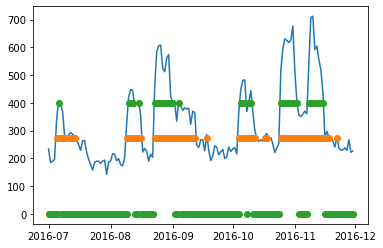

In [171]:
plt.plot(dfa['date'], dfa['receipts_count'])
c = np.quantile(dfa['receipts_count'], 0.5)
plt.plot(dfa['date'],(dfa['receipts_count']>c)*c,'o')
dfa['hight'] = (dfa['receipts_count']>c).astype(int)
c = np.quantile(dfa['receipts_count'], 0.75)
plt.plot(dfa['date'],(dfa['receipts_count']>c)*c, 'o')
dfa['veryhigh'] = (dfa['receipts_count']>c).astype(int)
plt.show()

In [172]:
dfa['receipts_count'] = np.log(dfa['receipts_count'])

In [173]:
dfa.head(3)

,brand_id,date,receipts_count,ad,month,dow,WeekDay,shift1,shift2,shift3,shift4,shift5,shift6,sum_sales_7,hight,veryhigh
1,178,2016-07-01,5.455321,0,7,4,1,185.0,190.0,196.0,336.0,408.0,397.0,1946.0,0,0
4,178,2016-07-02,5.220356,0,7,5,0,190.0,196.0,336.0,408.0,397.0,370.0,2082.0,0,0
7,178,2016-07-03,5.247024,0,7,6,0,196.0,336.0,408.0,397.0,370.0,282.0,2179.0,0,0


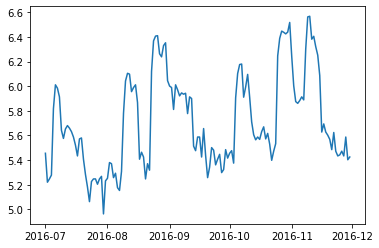

In [174]:
plt.plot(dfa['date'], dfa['receipts_count'])
plt.show()

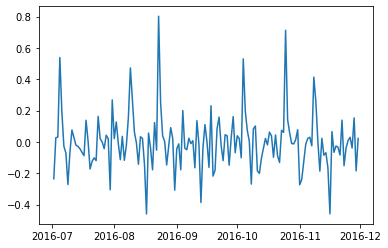

In [175]:
plt.plot(dfa['date'], dfa['receipts_count'].diff())
plt.show()

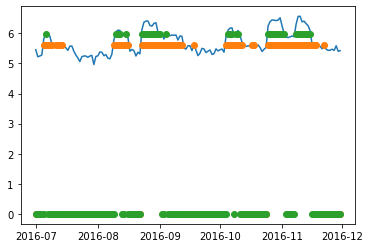

In [176]:
plt.plot(dfa['date'], dfa['receipts_count'])
c = np.quantile(dfa['receipts_count'], 0.5)
plt.plot(dfa['date'],(dfa['receipts_count']>c)*c,'o')
dfa['hight'] = (dfa['receipts_count']>c).astype(int)
c = np.quantile(dfa['receipts_count'], 0.75)
plt.plot(dfa['date'],(dfa['receipts_count']>c)*c, 'o')
dfa['veryhigh'] = (dfa['receipts_count']>c).astype(int)
plt.show()

In [177]:
import pmdarima as pm
# SARIMA Model
ex = pd.get_dummies(dfa[['month', 'dow']].astype(str), drop_first=True)
ex['hight'] = dfa['hight']
ex['veryhigh'] = dfa['veryhigh']
ex['date'] = dfa['date']
ex = ex.set_index('date')
endog = dfa.set_index('date')['receipts_count']

In [178]:
model_1 = pm.auto_arima(endog[1:], exogenous=ex[1:],
                       start_p=1, start_q=1 ,
                       max_p=14, max_q=14,
                       max_order=21,
                       m=1, seasonal=False, D=None,
                       d=0, stationary=True, test='adf',
                       with_intercept=True,
                       error_action='ignore', suppress_warnings=True,
                       trace=True, stepwise=True, random=True, maxiter=50,
                       n_fits=15,n_jobs=-1, 
                       )
model_1.summary()

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\pmdarima\arima\_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-188.797, Time=1.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-152.850, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-193.131, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-129.057, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=597.595, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-187.376, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-182.626, Time=0.76 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.59 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 5.303 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  152
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 111.566
Date:                Thu, 28 Jul 2022   AIC                           -193.131
Time:                        13:11:40   BIC                           -147.773
Sample:                    07-02-2016   HQIC                          -174.705
                         - 11-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3709      0.268      1.385      0.166      -0.154       0.896
month_11      -0.3372      0.264     -1.277      0.201      -0.855       0.180
month_7       -0.1083      0.349     -0.310      0.756      -0.792       0.576
month_8       -0.0427      0.340     -0.126      0.900      -0.709       0.623
month_9       -0.0970      0.377     -0.257      0.797      -0.836       0.642
dow_1          0.0457      0.024      1.910      0.056      -0.001       0.093
dow_2          0.0260      0.031      0.831      0.406      -0.035       0.087
dow_3          0.0698      0.040      1.757      0.079      -0.008       0.148
dow_4          0.0557      0.040      1.385      0.166      -0.023       0.135
dow_5         -0.0305      0.038     -0.804      0.422      -0.105       0.044
dow_6         -0.0031      0.028     -0.113      0.910      -0.058       0.051
hight          0.2476      0.021     11.563      0.000       0.206       0.290
veryhigh       0.2050      0.026      7.964      0.000       0.155       0.255
ar.L1          0.9340      0.047     19.853      0.000       0.842       1.026
sigma2         0.0133      0.002      8.327      0.000       0.010       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.48   Prob(JB):                         0.58
Heteroskedasticity (H):               1.21   Skew:                             0.20
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [179]:
model_2 = pm.auto_arima(endog[1:], exogenous=ex[1:],
                       start_p=1, start_q=1 ,
                       max_p=14, max_q=14,
                       max_order=21,
                       m=1, seasonal=False, D=None,
                       d=2, stationary=True, test='adf',
                       with_intercept=True,
                       error_action='ignore', suppress_warnings=True,
                       trace=True, stepwise=True, random=True, maxiter=50,
                       n_fits=15,n_jobs=-1, 
                       )
model_2.summary()

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\pmdarima\arima\_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-188.797, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-152.850, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-193.131, Time=0.61 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-129.057, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=597.595, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-187.376, Time=0.74 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-182.626, Time=0.78 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.54 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 4.759 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  152
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 111.566
Date:                Thu, 28 Jul 2022   AIC                           -193.131
Time:                        13:11:52   BIC                           -147.773
Sample:                    07-02-2016   HQIC                          -174.705
                         - 11-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3709      0.268      1.385      0.166      -0.154       0.896
month_11      -0.3372      0.264     -1.277      0.201      -0.855       0.180
month_7       -0.1083      0.349     -0.310      0.756      -0.792       0.576
month_8       -0.0427      0.340     -0.126      0.900      -0.709       0.623
month_9       -0.0970      0.377     -0.257      0.797      -0.836       0.642
dow_1          0.0457      0.024      1.910      0.056      -0.001       0.093
dow_2          0.0260      0.031      0.831      0.406      -0.035       0.087
dow_3          0.0698      0.040      1.757      0.079      -0.008       0.148
dow_4          0.0557      0.040      1.385      0.166      -0.023       0.135
dow_5         -0.0305      0.038     -0.804      0.422      -0.105       0.044
dow_6         -0.0031      0.028     -0.113      0.910      -0.058       0.051
hight          0.2476      0.021     11.563      0.000       0.206       0.290
veryhigh       0.2050      0.026      7.964      0.000       0.155       0.255
ar.L1          0.9340      0.047     19.853      0.000       0.842       1.026
sigma2         0.0133      0.002      8.327      0.000       0.010       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.48   Prob(JB):                         0.58
Heteroskedasticity (H):               1.21   Skew:                             0.20
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

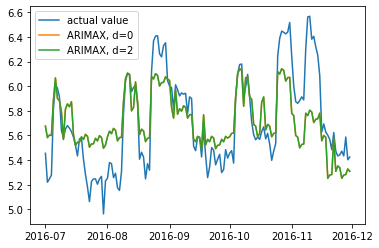

In [180]:
y_predict_log = model_1.predict(exogenous=ex,n_periods=len(ex))
'''
plt.plot(df['date'], np.exp(df['receipts_count']), label='actual value')
plt.plot(df['date'], np.exp(y_predict_log), label='ARIMAX, d=0')
'''
plt.plot(dfa['date'], dfa['receipts_count'], label='actual value')
plt.plot(dfa['date'],y_predict_log, label='ARIMAX, d=0')

y_predict_log = model_2.predict(exogenous=ex,n_periods=len(ex))
#plt.plot(df['date'], np.exp(y_predict_log), label='ARIMAX, d=1')
plt.plot(dfa['date'], y_predict_log, label='ARIMAX, d=2')
plt.legend()
plt.show()


# Анализ временных рядов
https://russianblogs.com/article/528249947/

In [181]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 1 to 457
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        153 non-null    int64         
 1   date            153 non-null    datetime64[ns]
 2   receipts_count  153 non-null    float64       
 3   ad              153 non-null    int8          
 4   month           153 non-null    int64         
 5   dow             153 non-null    int64         
 6   WeekDay         153 non-null    int32         
 7   shift1          152 non-null    float64       
 8   shift2          151 non-null    float64       
 9   shift3          150 non-null    float64       
 10  shift4          149 non-null    float64       
 11  shift5          148 non-null    float64       
 12  shift6          147 non-null    float64       
 13  sum_sales_7     147 non-null    float64       
 14  hight           153 non-null    int32         
 15  veryhi

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
# Решить искаженный отрицательный знак шкалы оси
plt.rcParams['axes.unicode_minus'] = False
# Решить китайскую искаженную проблему
plt.rcParams['font.sans-serif'] = ['Simhei']

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6

import warnings
warnings.filterwarnings("ignore")

In [192]:
dfa = df0[df0['brand_id']==178].copy() #ahmad
data = dfa.copy()

In [193]:
data.dtypes

brand_id                       int64
date                  datetime64[ns]
receipts_count                 int64
ad                              int8
month                          int64
dow                            int64
WeekDay                        int32
cluster                        int32
principal_feature1           float64
principal_feature2           float64
anomaly21                      int32
anomaly22                      int32
dtype: object

In [194]:
data.columns

Index(['brand_id', 'date', 'receipts_count', 'ad', 'month', 'dow', 'WeekDay',
       'cluster', 'principal_feature1', 'principal_feature2', 'anomaly21',
       'anomaly22'],
      dtype='object')

In [195]:
data.set_index('date',inplace=True)
data.index

DatetimeIndex(['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04',
               '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08',
               '2016-07-09', '2016-07-10',
               ...
               '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
               '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
               '2016-11-29', '2016-11-30'],
              dtype='datetime64[ns]', name='date', length=153, freq=None)

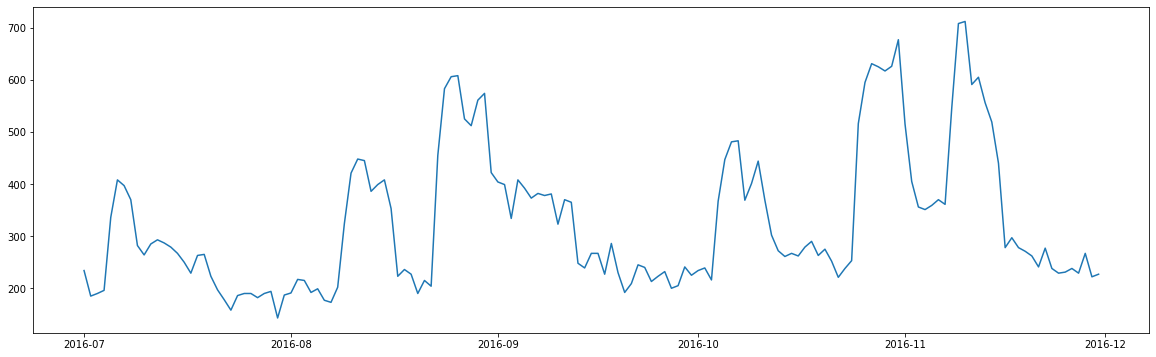

In [196]:
ts = data ['receipts_count']
plt.plot(ts);

In [197]:
ts.index

DatetimeIndex(['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04',
               '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08',
               '2016-07-09', '2016-07-10',
               ...
               '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
               '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
               '2016-11-29', '2016-11-30'],
              dtype='datetime64[ns]', name='date', length=153, freq=None)

In [198]:
ts['2016-07']

date
2016-07-01    234
2016-07-02    185
2016-07-03    190
2016-07-04    196
2016-07-05    336
2016-07-06    408
2016-07-07    397
2016-07-08    370
2016-07-09    282
2016-07-10    264
2016-07-11    285
2016-07-12    293
2016-07-13    287
2016-07-14    279
2016-07-15    267
2016-07-16    250
2016-07-17    229
2016-07-18    263
2016-07-19    265
2016-07-20    223
2016-07-21    197
2016-07-22    178
2016-07-23    158
2016-07-24    186
2016-07-25    190
2016-07-26    190
2016-07-27    182
2016-07-28    190
2016-07-29    194
2016-07-30    143
2016-07-31    187
Name: receipts_count, dtype: int64

**Тест стационарности**

In [199]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd =  timeseries.rolling(window=12, center=False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)


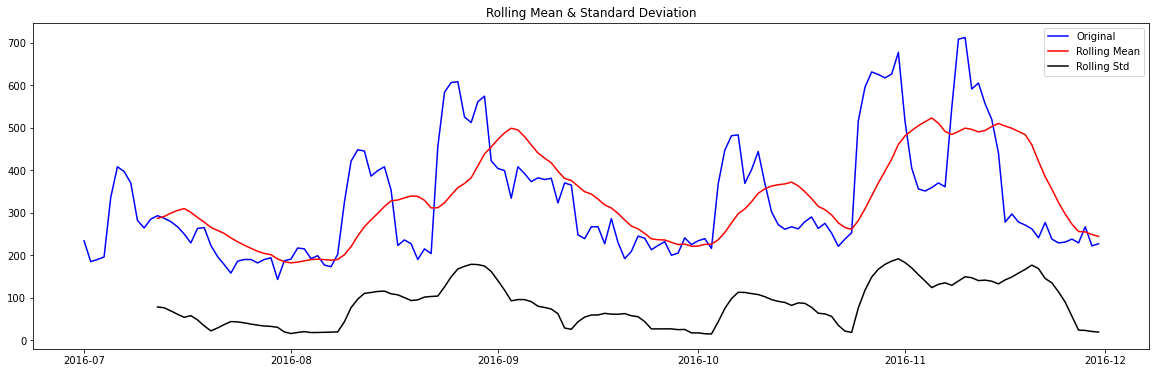

Results of Dickey-Fuller Test:
Test Statistic                  -2.195736
p-value                          0.207797
#Lags Used                       8.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [200]:
test_stationarity(ts)

р = 0.207797> 0.05 Последовательность не является стационарной, но вы также можете заметить, что среднее значение и дисперсия нестабильны

In [201]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Тест белого шума: тест Юнга-Бокса
def randomness(ts, lags=7):
    rdtest = acorr_ljungbox(ts,lags=lags)
    # Семантическое описание значения, полученного вышеуказанной функцией
    print(rdtest)
    rddata = np.c_[range(1,lags+1),rdtest[1:]]
    rdoutput = pd.DataFrame(rddata,columns=['lags','p-value'])
    return rdoutput.set_index('lags')

In [72]:
#randomness(ts)

**Обработка и оценка стационарности, устранение тенденций**

Первый трюк для устранения тренда - это логарифмическое преобразование. Потому что мы ясно видим, что наши данные показывают значительную тенденцию к росту. Поэтому мы можем применить преобразование журнала. Конечно, есть и другие методы преобразования, такие как: квадратный корень, кубический корень и так далее.

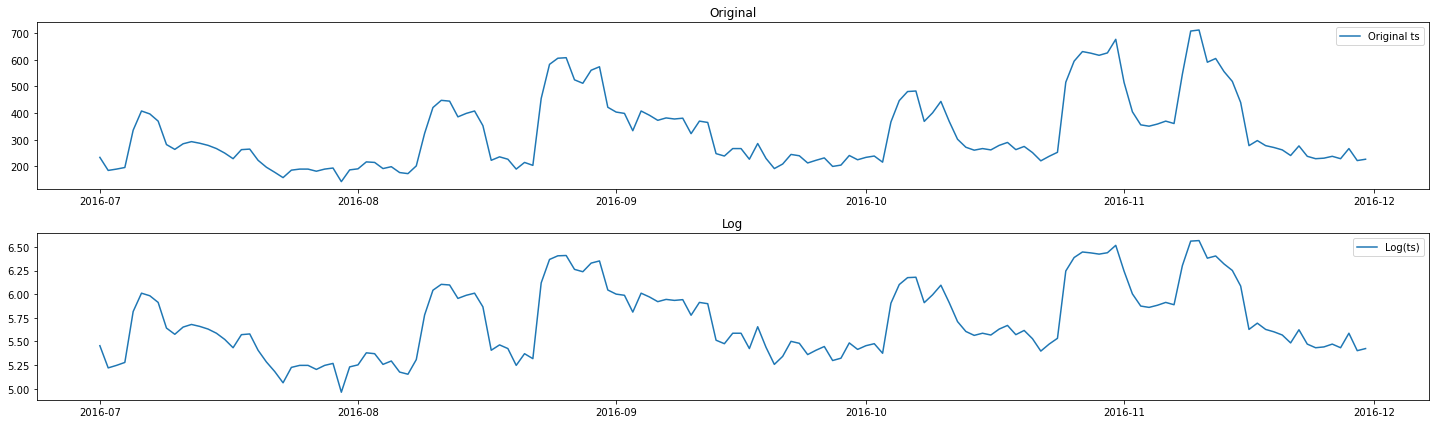

In [202]:
ts_log = np.log(ts)

# Plot original ts and log(ts):
plt.subplot(211)
plt.title('Original')
plt.plot(ts,label='Original ts')
plt.legend(loc='best')
plt.subplot(212)
plt.title('Log')
plt.plot(ts_log, label='Log(ts)')
plt.legend(loc='best')
plt.tight_layout()

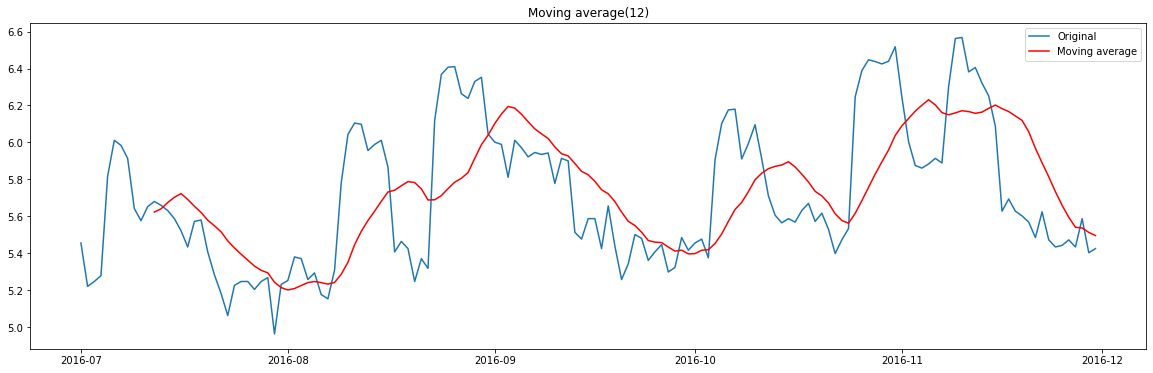

In [203]:
moving_avg = ts_log.rolling(window=12,center=False).mean()  # Окно 12
plt.plot(ts_log, label='Original')
plt.plot(moving_avg, color='red', label='Moving average')
plt.title('Moving average(12)')
plt.legend(loc='best');

In [204]:
# Удалить скользящее среднее
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(24)

date
2016-07-01         NaN
2016-07-02         NaN
2016-07-03         NaN
2016-07-04         NaN
2016-07-05         NaN
2016-07-06         NaN
2016-07-07         NaN
2016-07-08         NaN
2016-07-09         NaN
2016-07-10         NaN
2016-07-11         NaN
2016-07-12    0.057077
2016-07-13    0.019373
2016-07-14   -0.043136
2016-07-15   -0.115451
2016-07-16   -0.201517
2016-07-17   -0.257307
2016-07-18   -0.082282
2016-07-19   -0.041023
2016-07-20   -0.171386
2016-07-21   -0.265463
2016-07-22   -0.334036
2016-07-23   -0.404066
2016-07-24   -0.203046
Name: receipts_count, dtype: float64

In [205]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

date
2016-07-12    0.057077
2016-07-13    0.019373
2016-07-14   -0.043136
2016-07-15   -0.115451
2016-07-16   -0.201517
Name: receipts_count, dtype: float64

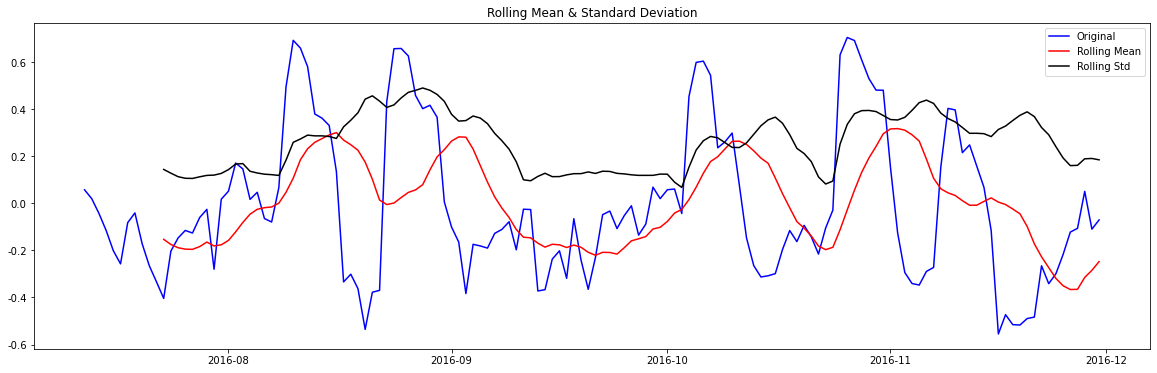

Results of Dickey-Fuller Test:
Test Statistic                  -5.192657
p-value                          0.000009
#Lags Used                       5.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


In [206]:
test_stationarity(ts_log_moving_avg_diff)

р = 0,0 <0,05. Можно сказать, что последовательность стабильна при 95% достоверности, а среднее значение и дисперсия НЕ стабильны, чем метод сглаживания

**Экспоненциально взвешенная скользящая средняя**

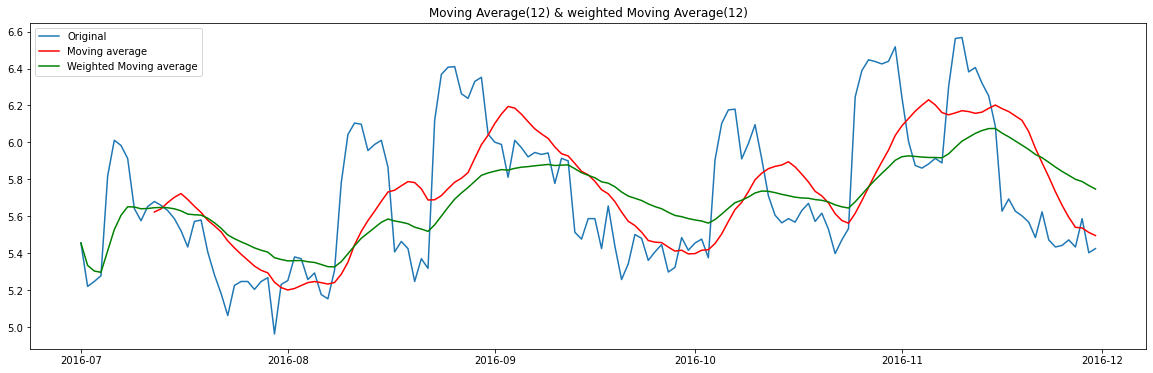

In [207]:
expwighted_avg = ts_log.ewm(min_periods=0, ignore_na=False, halflife=12, adjust=True).mean()
plt.plot(ts_log, label='Original')
plt.plot(moving_avg, color='red', label='Moving average')
plt.plot(expwighted_avg, color='green', label='Weighted Moving average')
# expwighted_avg.plot(style='k--')
plt.title('Moving Average(12) & weighted Moving Average(12)')
plt.legend(loc='best');

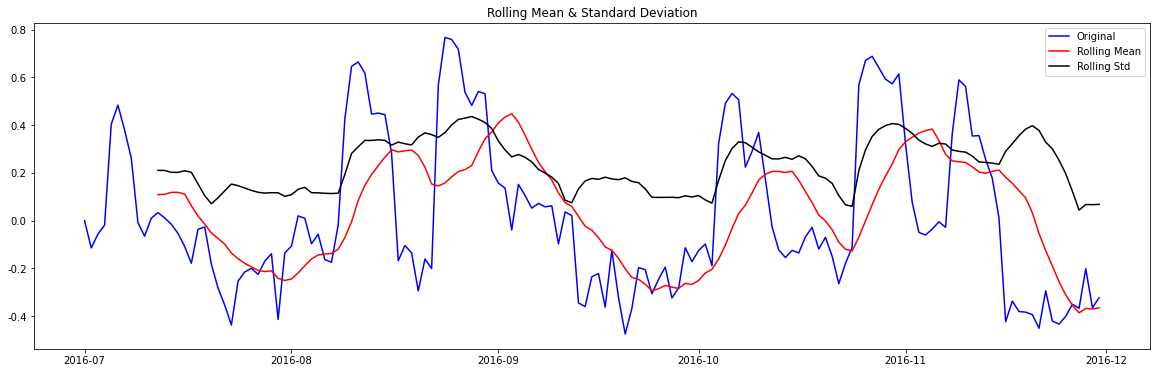

Results of Dickey-Fuller Test:
Test Statistic                  -3.891499
p-value                          0.002098
#Lags Used                       1.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


In [208]:
# Удалить экспоненциально взвешенное скользящее среднее
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

**ТО ЖЕ не айс**

Вышеупомянутые методы не являются хорошим решением всех проблем, особенно когда есть очевидные сезонные факторы. Ниже мы поговорим о двух общих и эффективных способах устранения трендов и сезонных факторов:

Дифференциал: внести изменения в определенный промежуток времени
Разложение: моделирование трендов и сезонности и удаление их из модели

**разница**

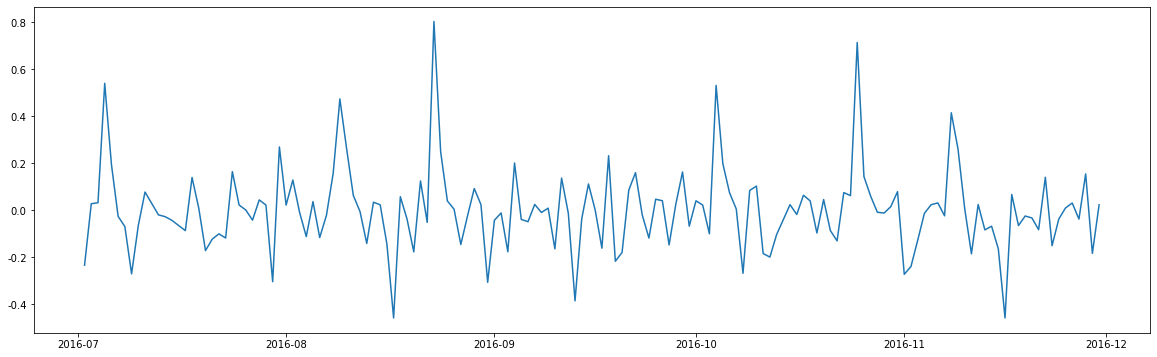

In [209]:
# Разница первого порядка
#ts_log_diff = ts_log - ts_log.shift()
ts_log_diff = ts_log.diff()
plt.plot(ts_log_diff);

In [210]:
ts_log_diff.shape

(153,)

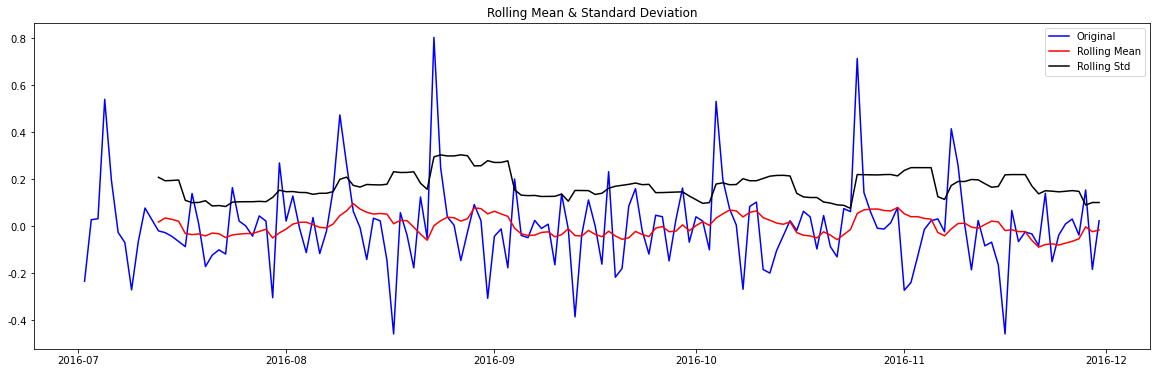

Results of Dickey-Fuller Test:
Test Statistic                -1.043280e+01
p-value                        1.594518e-18
#Lags Used                     0.000000e+00
Number of Observations Used    1.510000e+02
Critical Value (1%)           -3.474416e+00
Critical Value (5%)           -2.880878e+00
Critical Value (10%)          -2.577081e+00
dtype: float64


In [211]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

р = 1.594518e-18 Можно сказать, что последовательность стабильна при 99% достоверности, а среднее значение и дисперсия стабильны.

**декомпозиция**

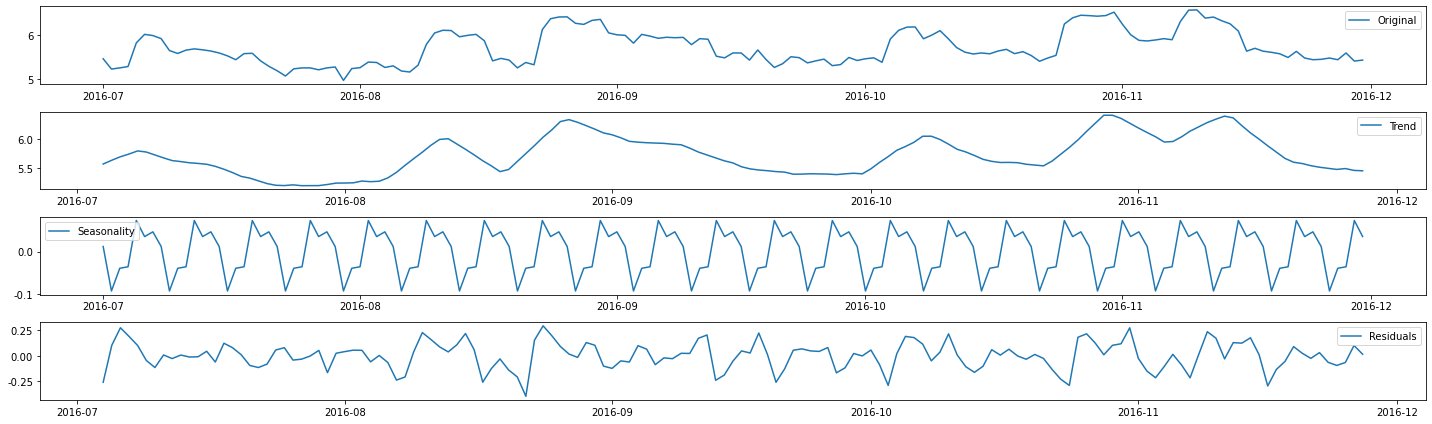

In [212]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

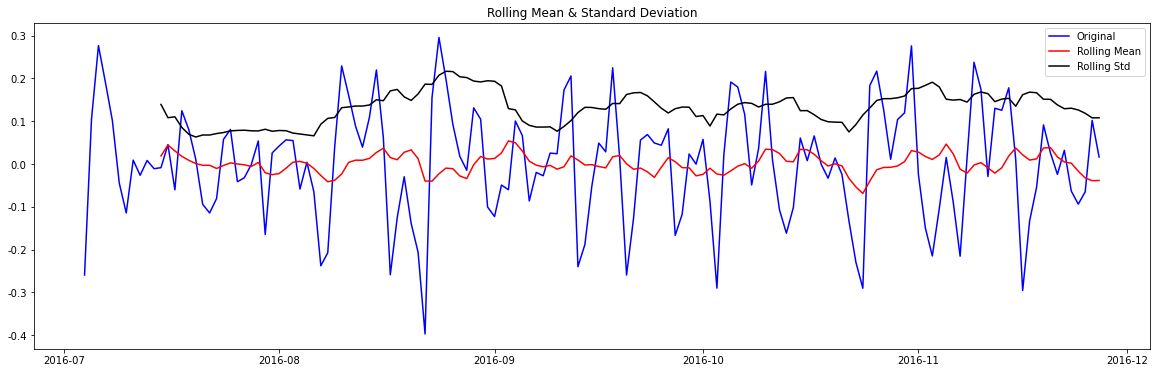

Results of Dickey-Fuller Test:
Test Statistic                -6.779793e+00
p-value                        2.516459e-09
#Lags Used                     1.000000e+01
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


In [213]:
# Проверка стационарности остатков
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Примерка модели
### ARMA

In [214]:
from statsmodels.tsa.arima.model import ARIMA

**ACF & PACF Plots**

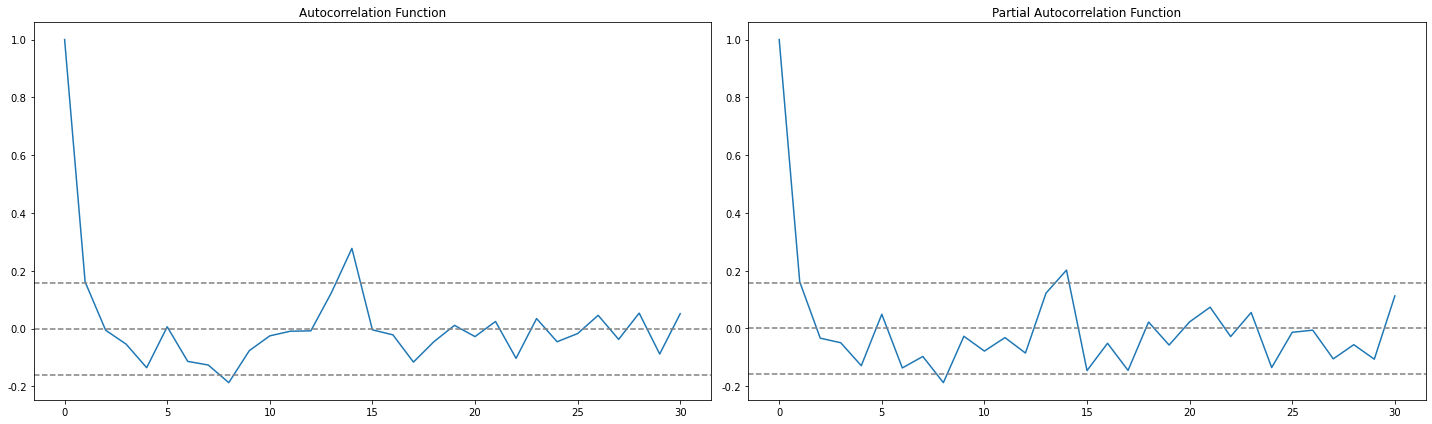

In [215]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

# ts_log_diff, Время после разницы первого порядка после преобразования журнала
lag_acf = acf(ts_log_diff, nlags=30)
lag_pacf = pacf(ts_log_diff, nlags=30, method='ols')

# Plot ACF:
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


Видно, что ACF и PACF впервые попали в доверительный интервал на уровне 2 соответственно

In [216]:
# На самом деле statsmodels предоставляет более удобные функции ACF и PACF.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [217]:
# График автокорреляции и частичной корреляции, порядок по умолчанию - 31
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white',figsize=(20,4))
    ax1 = f.add_subplot(121)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(122)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

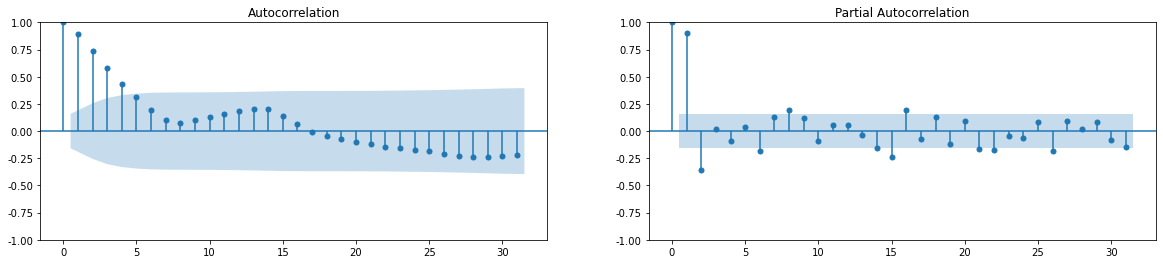

In [218]:
draw_acf_pacf(ts)

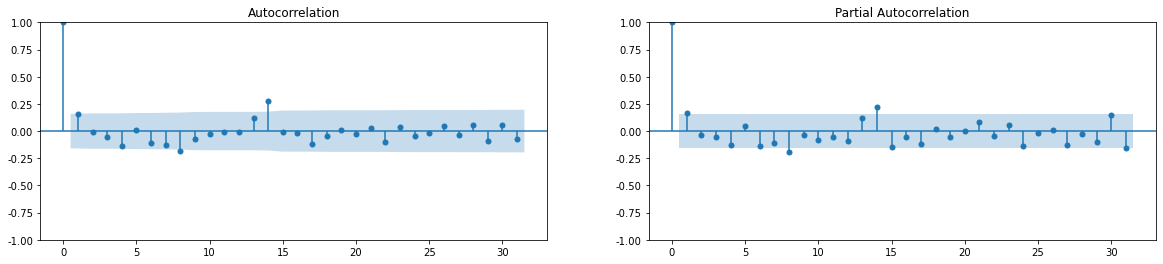

In [219]:
draw_acf_pacf(ts_log_diff)

**AR Model:**

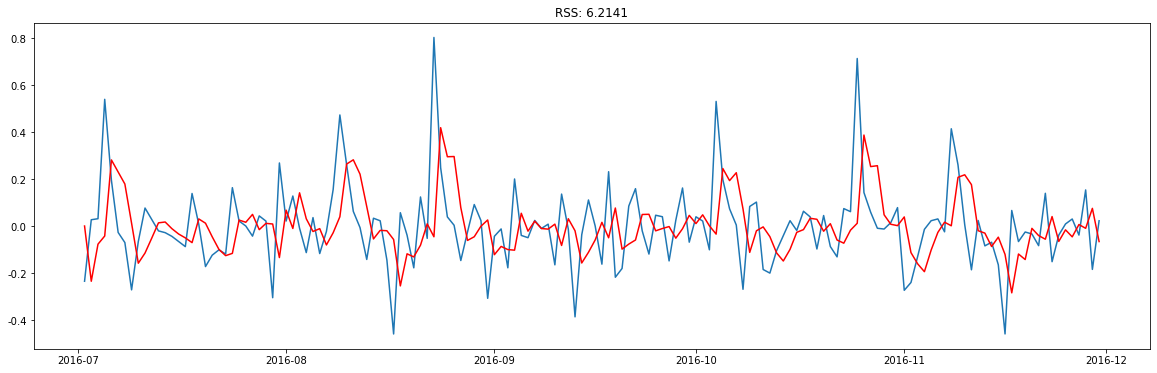

In [220]:
model = ARIMA(endog=ts_log_diff, order=(2,1,0))
results_AR = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: {:.4f}'.format(sum((results_AR.fittedvalues-ts_log_diff)**2)));

**MA Model**

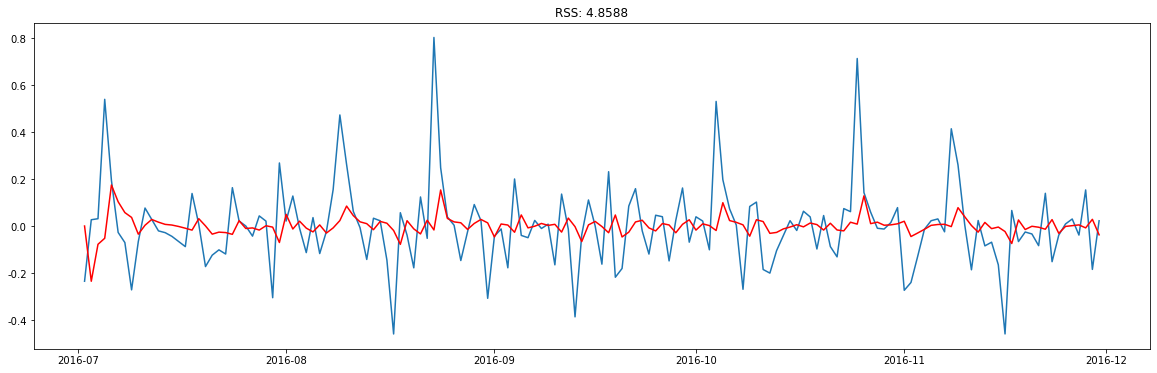

In [221]:
model = ARIMA(ts_log_diff, order=(0, 1, 2))  
results_MA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: {:.4f}'.format(sum((results_MA.fittedvalues-ts_log_diff)**2)));

**ARIMA Model:**

In [222]:
model = ARIMA(ts_log_diff, order=(2, 1, 0))  
results_ARIMA = model.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:         receipts_count   No. Observations:                  152
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  27.326
Date:                Thu, 28 Jul 2022   AIC                            -48.653
Time:                        13:19:09   BIC                            -39.601
Sample:                    07-02-2016   HQIC                           -44.976
                         - 11-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5053      0.085     -5.966      0.000      -0.671      -0.339
ar.L2         -0.2729      0.079     -3.432      0.001      -0.429      -0.117
sigma2         0.0407      0.004     11.249      0.0

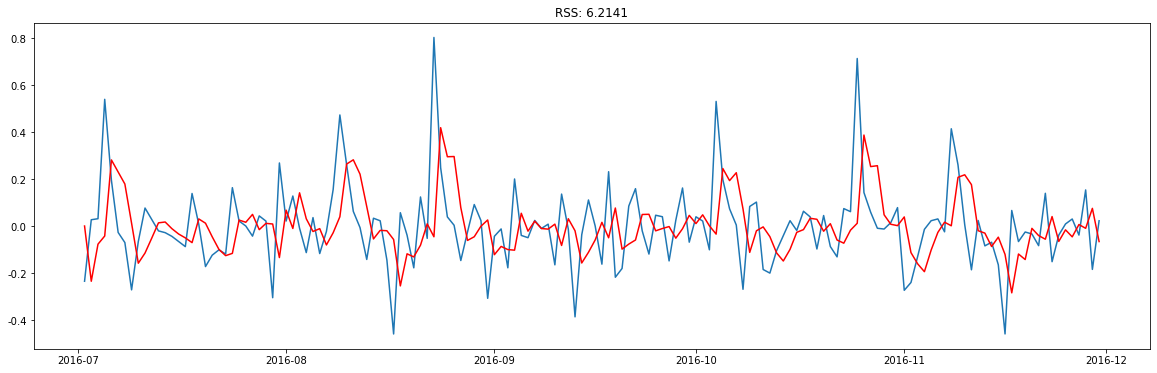

In [223]:
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: {:.4f}'.format(sum((results_ARIMA.fittedvalues-ts_log_diff)**2)));

**Преобразовать прогнозируемое значение в значение до преобразования:**

In [224]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2016-07-02    0.000000
2016-07-03   -0.234965
2016-07-04   -0.077200
2016-07-05   -0.042534
2016-07-06    0.281132
dtype: float64

In [225]:
predictions_ARIMA_diff.tail()

date
2016-11-26   -0.046065
2016-11-27    0.006271
2016-11-28   -0.009757
2016-11-29    0.075130
2016-11-30   -0.066132
dtype: float64

In [226]:
# Устранить последствия различий первого порядка
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2016-07-02    0.000000
2016-07-03   -0.234965
2016-07-04   -0.312165
2016-07-05   -0.354699
2016-07-06   -0.073567
dtype: float64

In [227]:
ts_log_diff.iloc[0]

-0.2349652902793773

In [228]:
# Добавьте обратно значение 1949-01-01 и используйте его в качестве основы, прежде чем переходить к разнице.
predictions_ARIMA_log = pd.Series(ts_log_diff.iloc[0], index=ts_log_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
2016-07-02   -0.234965
2016-07-03   -0.469931
2016-07-04   -0.547131
2016-07-05   -0.589664
2016-07-06   -0.308532
dtype: float64

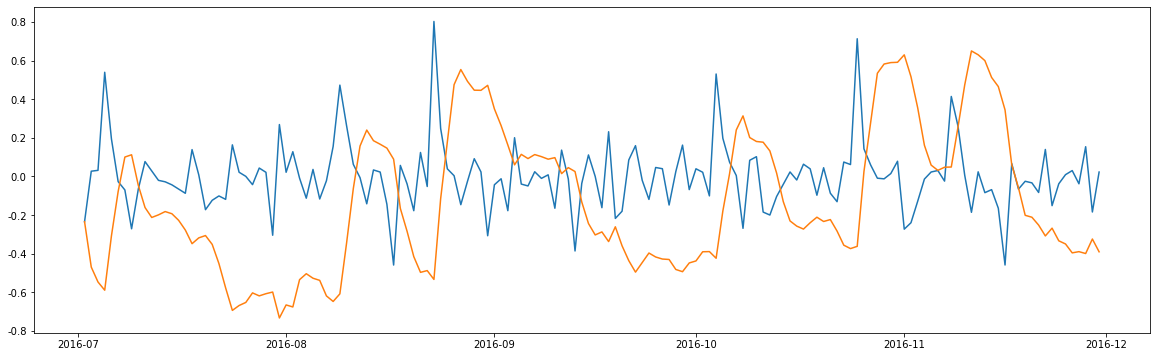

In [229]:
plt.plot(ts_log_diff)
plt.plot(predictions_ARIMA_log);

In [230]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA.head()

date
2016-07-02    0.790598
2016-07-03    0.625046
2016-07-04    0.578608
2016-07-05    0.554513
2016-07-06    0.734524
dtype: float64

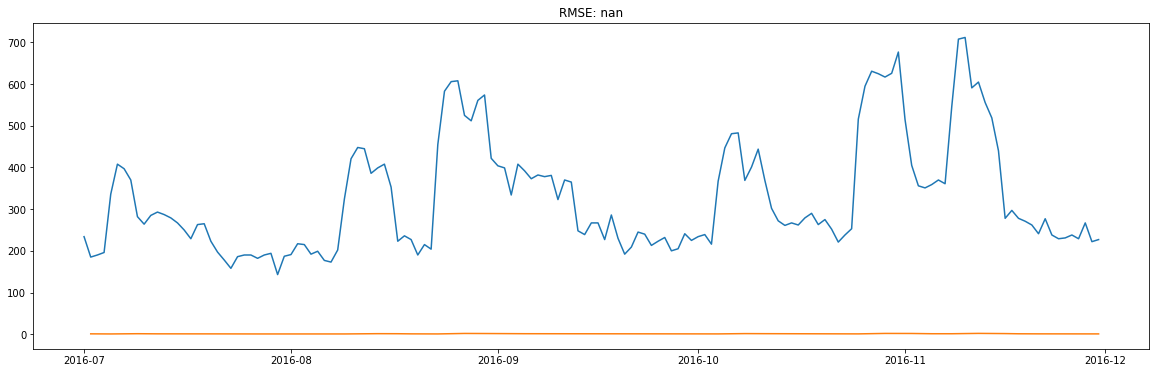

In [231]:
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: {:.4f}'.format(np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts))));

**SARMAX**

In [232]:
import statsmodels.api as sm

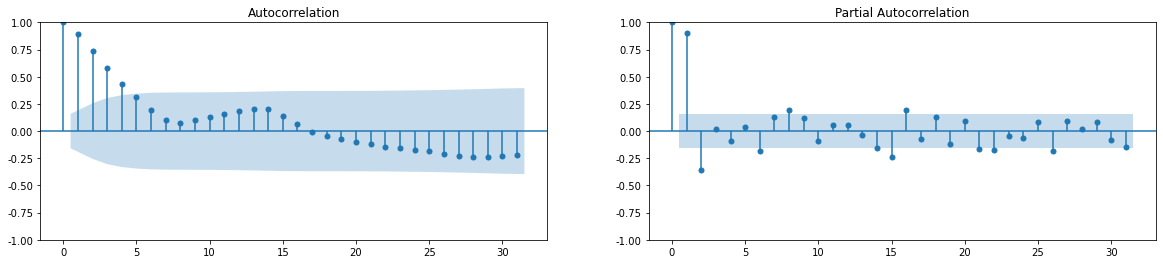

In [233]:
draw_acf_pacf(ts)

In [234]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(ts_log, order=(1,1,1), seasonal_order=(1,0,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                    D.receipts_count   No. Observations:                  152
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                  50.086
Date:                             Thu, 28 Jul 2022   AIC                            -92.172
Time:                                     13:19:27   BIC                            -80.077
Sample:                                 07-02-2016   HQIC                           -87.258
                                      - 11-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0378      0.894      0.042      0.966      -1.715       1.791
ma.L1          0.1313      

In [235]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 12
predict = res.get_prediction(end=mod.nobs + nforecast)

In [236]:
# Устранить последствия различий первого порядка
pred_log = pd.Series(ts_log.iloc[0], index=ts_log[[0]].index)
pred_log = pred_log.add(predict.predicted_mean, fill_value=0).cumsum()
# Логарифмическое сокращение
pred_ARIMA = np.exp(pred_log)

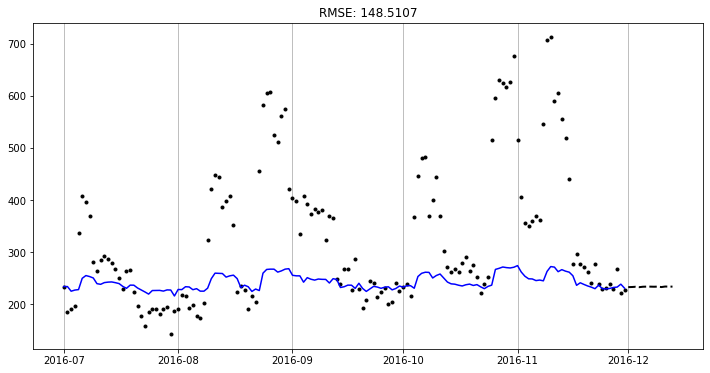

In [237]:
# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(ts, 'k.')
# Plot
ax.plot(pred_ARIMA[:-nforecast-1], 'b')
ax.plot(pred_ARIMA[-nforecast-1:], 'k--', linestyle='--', linewidth=2)
ax.set(title='RMSE: {:.4f}'.format(np.sqrt(sum((pred_ARIMA[:-nforecast-1]-ts)**2)/len(ts))));

**Дальнейший тюнинг**

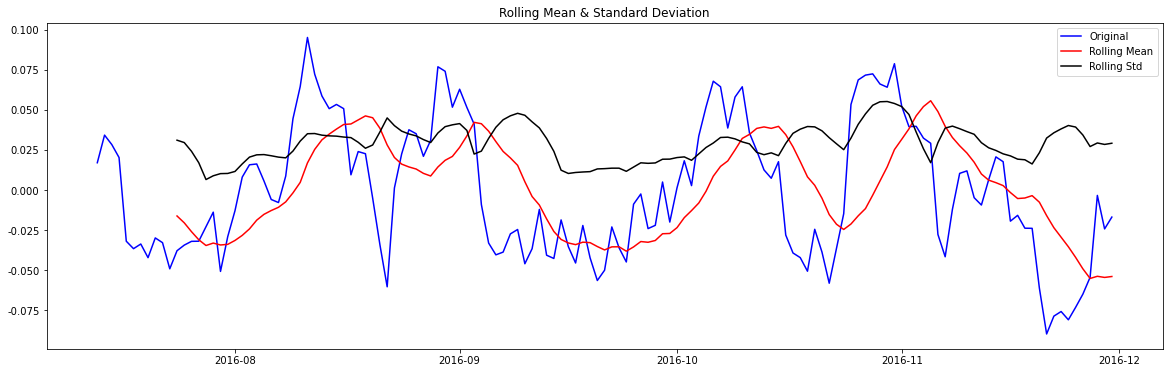

Results of Dickey-Fuller Test:
Test Statistic                  -2.636869
p-value                          0.085614
#Lags Used                      14.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64


In [238]:
# преобразование журнала, гладкое, разность первого порядка
ts_log = np.log(ts)
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
test_stationarity(ts_diff_1)

In [239]:
# Разница второго порядка
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)

In [240]:
#from statsmodels.tsa.arima.model import ARIMA
# Подгонка модели
model = ARIMA(ts_diff_2, order=(1, 0, 1))
result_arma = model.fit()

In [241]:
# Прогноз
result_arma.fittedvalues.head()

date
2016-07-14   -0.000179
2016-07-15    0.001703
2016-07-16   -0.002544
2016-07-17    0.000959
2016-07-18   -0.008201
dtype: float64

In [242]:
print(result_arma.summary())

                               SARIMAX Results                                
Dep. Variable:         receipts_count   No. Observations:                  140
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 347.026
Date:                Thu, 28 Jul 2022   AIC                           -686.053
Time:                        13:19:45   BIC                           -674.286
Sample:                    07-14-2016   HQIC                          -681.271
                         - 11-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.091      0.927      -0.004       0.004
ar.L1         -0.7785      0.094     -8.285      0.000      -0.963      -0.594
ma.L1          0.9645      0.041     23.544      0.0

In [243]:
# AIC，BIC
result_arma.aic, result_arma.bic

(-686.0526630685533, -674.2860933781161)

In [244]:
# AR, MA оценка параметров модели
result_arma.arparams, result_arma.maparams

(array([-0.77853582]), array([0.96449355]))

In [245]:
# Прогноз
predict_ts = result_arma.predict()
predict_ts.head(), predict_ts.tail()

(2016-07-14   -0.000179
 2016-07-15    0.001703
 2016-07-16   -0.002544
 2016-07-17    0.000959
 2016-07-18   -0.008201
 Freq: D, Name: predicted_mean, dtype: float64,
 2016-11-26    0.005195
 2016-11-27   -0.003799
 2016-11-28    0.005308
 2016-11-29    0.004057
 2016-11-30   -0.008116
 Freq: D, Name: predicted_mean, dtype: float64)

In [246]:
from pandas import datetime

start_index = datetime(2016, 11, 15)
end_index = datetime(2016, 11, 30)
pred = result_arma.predict(start=start_index, end=end_index)
pred.head(), pred.tail()

(2016-11-15    0.004421
 2016-11-16   -0.005143
 2016-11-17   -0.002254
 2016-11-18    0.002531
 2016-11-19   -0.004251
 Freq: D, Name: predicted_mean, dtype: float64,
 2016-11-26    0.005195
 2016-11-27   -0.003799
 2016-11-28    0.005308
 2016-11-29    0.004057
 2016-11-30   -0.008116
 Freq: D, Name: predicted_mean, dtype: float64)